In [2]:
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')

from src.chemkin_wrapper import chemkin_wrapper, plot_outputs
from src.chemkin import CHEMKIN 
from src.hychem import CONDITION, HYCHEM

%reload_ext autoreload
%autoreload 2

In [3]:
# d = chemkin_wrapper("../workingdir")
# d.head()
# plot_outputs(d)

Temperature: 1300 K
Pressure: 4 atm
POSF10325: 0.004 (fraction)
AR: 0.996 (fraction)



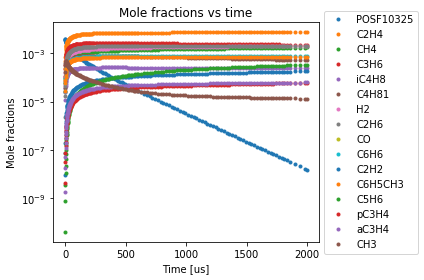

In [6]:
ck = CHEMKIN()
cond = CONDITION(1300, 4, {'POSF10325': .004, 'AR': .996})
print(cond)
ck.chemkin_wrapper("../workingdir", cond).head()
ck.plot_outputs(log="xy")